In [1]:
# Parameters
param_dict = {
  "cave": {
    "crop": {
      "top_left": {
        "x": 180,
        "y": 90
      },
      "bottom_right": {
        "x": 330,
        "y": 280
      }
    },
    "center": {
      "x": 72,
      "y": 100
    },
    "curve": {
      "x": 131,
      "y": 180,
    },
    "start": {
      "angle": 144.5,
      "value": 0.4
    },
    "end": {
      "angle": 404,
      "value": 10
    },

    "number_of_shape_countours_threshold": 150,
    "threshold_value": 90,
    "threshold_brightness": 255,
    "minLineLength": 40,
    "maxLineGap": 1
  },
  "water": {
    "crop": {
      "top_left": {
        "x": 100,
        "y": 100
      },
      "bottom_right": {
        "x": 600,
        "y": 600
      }
    },
    "center": {
      "x": 248,
      "y": 330
    },
    "curve": {
      "x": 430,
      "y": 430,
    },
    "start": {
      "angle": 223,
      "value": 100
    },
    "end": {
      "angle": 316,
      "value": 250
    },

    "number_of_shape_countours_threshold": 150,
    "threshold_value": 60,
    "threshold_brightness": 20,
    "threashold_reverse": True,
    "minLineLength": 170,
    "maxLineGap": 30
  },
  "gauge_1": {
    "crop": {
      "top_left": {
        "x": 50,
        "y": 50
      },
      "bottom_right": {
        "x": 650,
        "y": 650
      }
    },
    "center": {
      "x": 295,
      "y": 305
    },
    "curve": {
      "x": 500,
      "y": 500,
    },
    "start": {
      "angle": 135,
      "value": 0
    },
    "end": {
      "angle": 406,
      "value": 1000
    },

    "number_of_shape_countours_threshold": 150,
    "threshold_value": 190,
    "threshold_brightness": 130,
    "minLineLength": 90,
    "maxLineGap": 0
  },
}

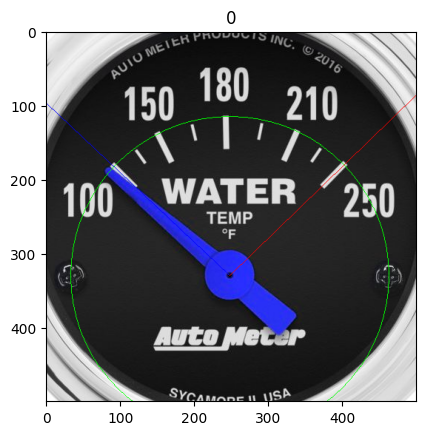

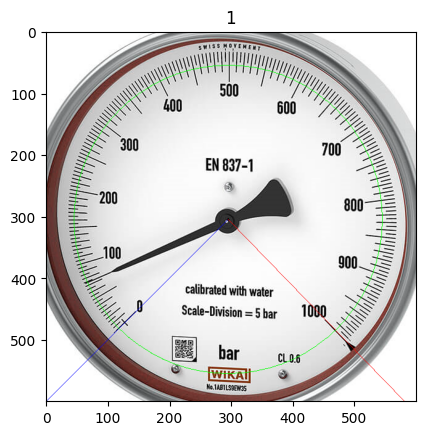

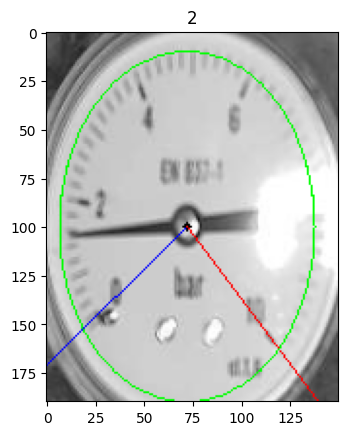

Type: water
Params: {'crop': {'top_left': {'x': 100, 'y': 100}, 'bottom_right': {'x': 600, 'y': 600}}, 'center': {'x': 248, 'y': 330}, 'curve': {'x': 430, 'y': 430}, 'start': {'angle': 223, 'value': 100}, 'end': {'angle': 316, 'value': 250}, 'number_of_shape_countours_threshold': 150, 'threshold_value': 60, 'threshold_brightness': 20, 'threashold_reverse': True, 'minLineLength': 170, 'maxLineGap': 30}
Type: gauge_1
Params: {'crop': {'top_left': {'x': 50, 'y': 50}, 'bottom_right': {'x': 650, 'y': 650}}, 'center': {'x': 295, 'y': 305}, 'curve': {'x': 500, 'y': 500}, 'start': {'angle': 135, 'value': 0}, 'end': {'angle': 406, 'value': 1000}, 'number_of_shape_countours_threshold': 150, 'threshold_value': 190, 'threshold_brightness': 130, 'minLineLength': 90, 'maxLineGap': 0}
Type: cave
Params: {'crop': {'top_left': {'x': 180, 'y': 90}, 'bottom_right': {'x': 330, 'y': 280}}, 'center': {'x': 72, 'y': 100}, 'curve': {'x': 131, 'y': 180}, 'start': {'angle': 144.5, 'value': 0.4}, 'end': {'angle'

In [2]:
from matplotlib import pyplot as plt
import cv2
import glob
import re
import numpy as np

# List all images with name image{X}.png
image_files = glob.glob('image_*_main.*')

# Load all images using cv2
images = [cv2.imread(image_file) for image_file in image_files]

# Extract the type part from the file name
type_pattern = re.compile(r'image_(.*?)_main\..*')
types = [type_pattern.search(file).group(1) for file in image_files]

ellipses = []

for i in range(len(images)):
  params = param_dict.get(types[i], None)

  ellipses.append(None)

  if params is None:
    continue

  
  crop_data = params.get("crop")
  top_left = (crop_data.get("top_left").get("x"), crop_data.get("top_left").get("y"))
  bottom_right = (crop_data.get("bottom_right").get("x"), crop_data.get("bottom_right").get("y"))
  
  images[i] = images[i][top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

  cp = images[i].copy()

  # Draw the center from params "center"
  center = (params.get("center").get("x"), params.get("center").get("y"))
  curve = (params.get("curve").get("x"), params.get("curve").get("y"))
  cv2.circle(cp, center, 2, (0,0,0), -1)

  # Draw the start point from params "start"
  # start = (params.get("start").get("x"), params.get("start").get("y"))
  start_angle = params.get("start").get("angle")
  start_angle_rad = np.radians(start_angle)
  start = (int(center[0] + curve[0] * np.cos(start_angle_rad)), int(center[1] + curve[1] * np.sin(start_angle_rad)))
  cv2.line(cp, center, start, (0, 0, 255), 1)

   # Draw the end point from params "end"
  # end = (params.get("end").get("x"), params.get("end").get("y"))
  end_angle = params.get("end").get("angle")
  end_angle_rad = np.radians(end_angle)
  end = (int(center[0] + curve[0] * np.cos(end_angle_rad)), int(center[1] + curve[1] * np.sin(end_angle_rad)))
  cv2.line(cp, center, end, (255, 0, 0), 1)

  ellipse = (center, (params.get("curve").get("x"), params.get("curve").get("y")), 0)
  ellipses[i] = ellipse

  cv2.ellipse(cp, ellipse, (0, 255, 0), 1)

  plt.imshow(cp)
  plt.title(i)
  plt.show()

for i in range(len(images)):
  print("Type:", types[i])
  print("Params:", param_dict.get(types[i], None))


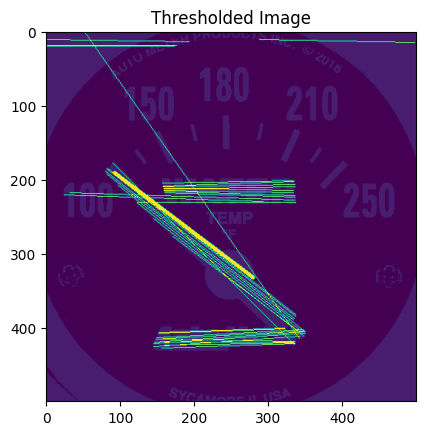

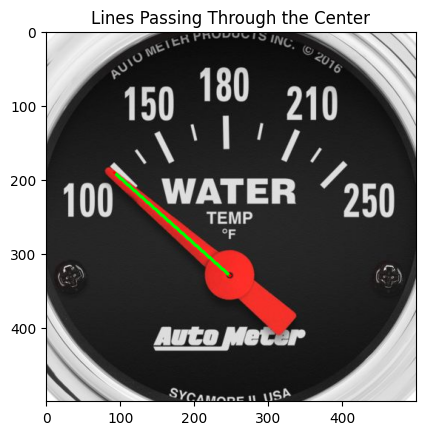

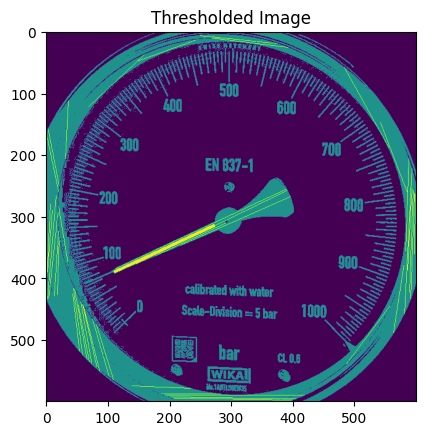

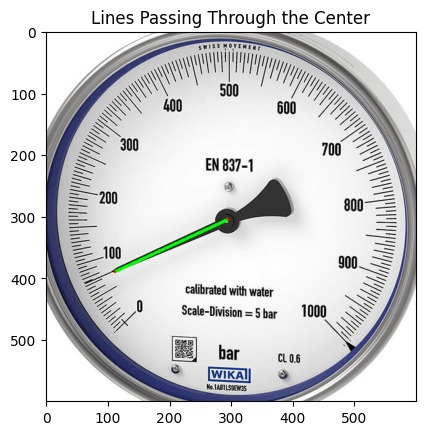

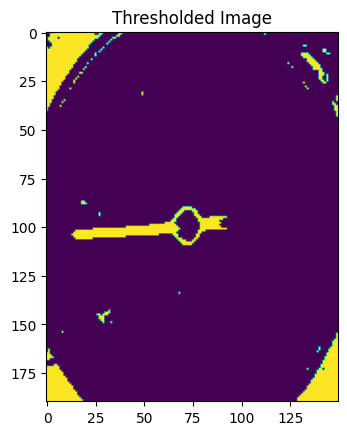

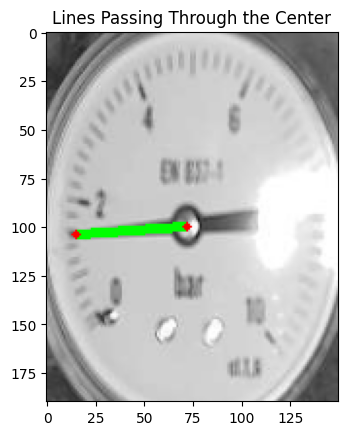

In [3]:

import lib.helpers as helpers

needle_points = []
for a in range(len(images)):
  params = param_dict.get(types[a], None)
  needle_points.append(None)
  ellipse = ellipses[a]

  if ellipse is None:
    continue

  needle_point, filtered_lines, all, dst2 = helpers.find_needle(images[a], ellipse, params.get("threshold_value"), params.get("threshold_brightness"), params.get("minLineLength"), params.get("maxLineGap"), params.get("threashold_reverse"))

  thresh = dst2.copy()
  render_needle = images[a].copy()

  if not needle_point is None:
    needle_points[a] = needle_point
     # Draw the lines on the ROI
    cv2.line(render_needle, needle_point, ellipse[0], (0, 255, 0), 3)

    # Draw the furthest point on the ROI
    cv2.circle(render_needle, needle_point, 2, (0, 0, 255), -1)

    # Draw the center of the ROI
    cv2.circle(render_needle, ellipse[0], 2, (0, 0, 255), -1)


  # Draw all the filtered lines on the ROI
  for line in all:
    x1, y1, x2, y2 = line[0]
    cv2.line(thresh, (x1, y1), (x2, y2), (255, 0, 0), 1)

  # Draw all the filtered lines on the ROI
  for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(thresh, (x1, y1), (x2, y2), (255, 0, 255), 3)

 
  # Display the image dst2
  plt.imshow(thresh)
  plt.title('Thresholded Image')
  plt.show()

  # Display the image with lines
  plt.imshow(cv2.cvtColor(render_needle, cv2.COLOR_BGR2RGB))
  plt.title('Lines Passing Through the Center')
  plt.show()

Files matching pattern 'image_water_*': ['image_water_main.jpg']
start 2.522000769131806 end 7.051130178057091 needle -2.411874582507066
distance -4.933875351638872 ignored 1.7540558982543004 ratio -1.089365064711107 gauge size 4.529129408925286
Value -63.404759706666056


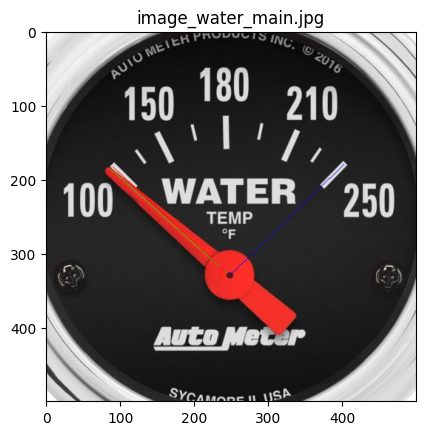

Files matching pattern 'image_gauge_1_*': ['image_gauge_1_main.png']
start 3.8920842319473548 end 5.515240436302081 needle 2.7119820735210673
distance -1.1801021584262874 ignored 4.6600291028248595 ratio -0.7270416459366141 gauge size 1.6231562043547263
Value -727.0416459366141


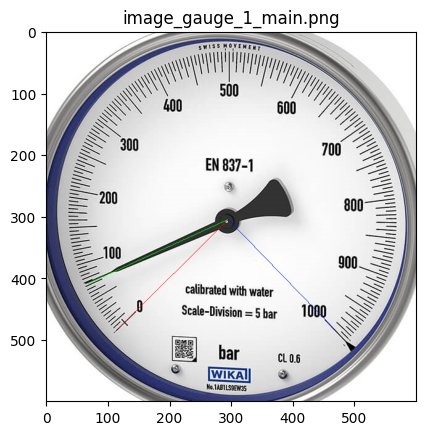

Files matching pattern 'image_cave_*': ['image_cave_1.png', 'image_cave_main.png']
start 2.356194490192345 end 7.086036763096978 needle 3.1264422977150232
distance 0.7702478075226784 ignored 1.5533430342749526 ratio 0.1628485186356253 gauge size 4.729842272904633
Value 1.9633457789020028


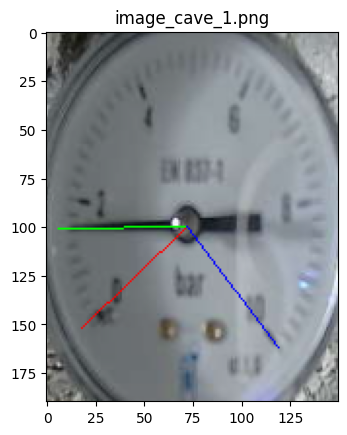

start 2.522000769131806 end 7.051130178057091 needle 3.050932766389048
distance 0.5289319972572422 ignored 1.7540558982543004 ratio 0.11678447434398924 gauge size 4.529129408925286
Value 1.5211309537022966


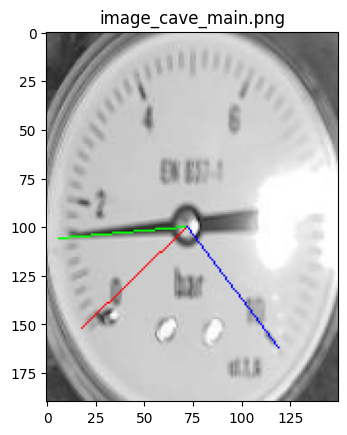

In [ ]:
import numpy as np

# Look for files matching the pattern "image_{type}_{x}.png"
for a in range(len(images)):
  pattern = f'image_{types[a]}_*'
  matching_files = glob.glob(pattern)
  params = param_dict.get(types[a], None)
  
  print(f"Files matching pattern '{pattern}': {matching_files}")

  # Load each matching image using cv2
  for file in matching_files:
    image = cv2.imread(file)

    ellipse = ellipses[a]

    if ellipse is None or params is None:
      continue

    center = ellipse[0]
    radius_x = ellipse[1][0] / 2
    radius_y = ellipse[1][1] / 2

    crop_data = params.get("crop")
    top_left = (crop_data.get("top_left").get("x"), crop_data.get("top_left").get("y"))
    bottom_right = (crop_data.get("bottom_right").get("x"), crop_data.get("bottom_right").get("y"))
    
    cropped = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]].copy()

    needle, filtered, all, _ = helpers.find_needle(cropped, ellipse, params.get("threshold_value"), params.get("threshold_brightness"), params.get("minLineLength"), params.get("maxLineGap"), params.get("threashold_reverse"))

    if not needle is None:
      needle_angle_rad = np.arctan2(needle[1] - ellipse[0][1], needle[0] - ellipse[0][0])
      needle_angle = np.degrees(needle_angle_rad)

      new_needle_point = (int(ellipse[0][0] + radius_x * np.cos(needle_angle_rad)), int(ellipse[0][1] + radius_y * np.sin(needle_angle_rad)))

      gauge_value = helpers.calculate_gauge_value(ellipse, new_needle_point, start_angle, end_angle, params.get("start").get("value"), params.get("end").get("value"))

      print("Value", gauge_value)

      # Draw the needle on the cropped image
      cv2.line(cropped, new_needle_point, ellipse[0], (0, 255, 0), 1)
    else:
      print("No needle found")

    # Display result
    start_angle = params.get("start").get("angle")
    start_angle_rad = np.deg2rad(start_angle)
    start = (int(ellipse[0][0] + radius_x * np.cos(start_angle_rad)), int(ellipse[0][1] + radius_y * np.sin(start_angle_rad)))

    end_angle = params.get("end").get("angle")
    end_angle_rad = np.deg2rad(end_angle)
    end = (int(ellipse[0][0] + radius_x * np.cos(end_angle_rad)), int(ellipse[0][1] + radius_y * np.sin(end_angle_rad)))

    crop_data = params.get("crop")
    top_left = (crop_data.get("top_left").get("x"), crop_data.get("top_left").get("y"))
    bottom_right = (crop_data.get("bottom_right").get("x"), crop_data.get("bottom_right").get("y"))
        
    # Draw the start angle line
    cv2.line(cropped, center, start, (0, 0, 255), 1)

    # Draw the end angle line
    cv2.line(cropped, center, end, (255, 0, 0), 1)

    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(file)
    plt.show()

